In [1]:
import torch
import h5py
import yaml
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import interpolate
from omegaconf import OmegaConf
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
import pytorch_lightning as pl

from ldm.util import instantiate_from_config

/scratch/coop/drozda/torch-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class VQVAEDataset(torch.utils.data.Dataset):
    """
    Dataset for VQ-VAE training.
    Only needs high-resolution images for reconstruction.
    """
    
    def __init__(self, hr_arrays):
        """
        Args:
            hr_arrays: torch.Tensor of shape (N, C, H, W)
        """
        assert isinstance(hr_arrays, torch.Tensor), "hr_arrays must be a torch.Tensor"
        assert hr_arrays.ndim == 4, f"hr_arrays must be 4D tensor, got shape {hr_arrays.shape}"
        
        self.hr = hr_arrays
        self.num_samples = hr_arrays.shape[0]
        
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        """
        Returns dictionary with 'image' key.
        VQModelInterface expects shape (H, W, C) for input.
        """
        hr_sample = self.hr[idx]  # Shape: (C, H, W)
        hr_sample = hr_sample.permute(1, 2, 0)  # Convert to (H, W, C)
        
        return {'image': hr_sample}

In [3]:
# Load JAX-CFD normalized data (range [-1,1])
path = 'data/data_normalized.h5'
hr_data = torch.from_numpy(h5py.File(path, 'r')['hr'][:])

# Create RGB tensor from data
hr_tensor = torch.stack([hr_data for _ in range(3)], 1)

# Split into train and validation
train_size = int(0.9 * len(hr_tensor))
val_size = len(hr_tensor) - train_size

hr_train = hr_tensor[:train_size]
hr_val = hr_tensor[train_size:]

train_dataset = VQVAEDataset(hr_train)
val_dataset = VQVAEDataset(hr_val)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"HR tensor shape: {hr_tensor.shape}")

Train samples: 460
Val samples: 52
HR tensor shape: torch.Size([512, 3, 256, 256])


In [4]:
# Set PyTorch DataLoaders
batch_size = 8

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 58
Val batches: 7


In [5]:
class ManualVQVAE(pl.LightningModule):
    """
    Wrapper for VQModelInterface that uses manual optimization.
    Required for PyTorch Lightning >= 2.0 which doesn't support optimizer_idx.
    """
    def __init__(self, vqvae_model):
        super().__init__()
        self.vqvae = vqvae_model
        # Enable manual optimization
        self.automatic_optimization = False
        
    def forward(self, x):
        return self.vqvae(x)
    
    def get_input(self, batch, k):
        return self.vqvae.get_input(batch, k)
    
    def training_step(self, batch, batch_idx):
        opt_ae, opt_disc = self.optimizers()
        
        x = self.get_input(batch, self.vqvae.image_key)
        xrec, qloss, ind = self.vqvae(x, return_pred_indices=True)
        
        # Optimize autoencoder
        aeloss, log_dict_ae = self.vqvae.loss(
            qloss, x, xrec, 0, self.global_step,
            last_layer=self.vqvae.get_last_layer(),
            split="train",
            predicted_indices=ind
        )
        
        opt_ae.zero_grad()
        self.manual_backward(aeloss)
        opt_ae.step()
        
        # Optimize discriminator
        discloss, log_dict_disc = self.vqvae.loss(
            qloss, x, xrec, 1, self.global_step,
            last_layer=self.vqvae.get_last_layer(),
            split="train"
        )
        
        opt_disc.zero_grad()
        self.manual_backward(discloss)
        opt_disc.step()
        
        # Logging
        self.log_dict(log_dict_ae, prog_bar=False, logger=True, on_step=True, on_epoch=True)
        self.log_dict(log_dict_disc, prog_bar=False, logger=True, on_step=True, on_epoch=True)
        
    def validation_step(self, batch, batch_idx):
        x = self.get_input(batch, self.vqvae.image_key)
        xrec, qloss, ind = self.vqvae(x, return_pred_indices=True)
        
        aeloss, log_dict_ae = self.vqvae.loss(
            qloss, x, xrec, 0, self.global_step,
            last_layer=self.vqvae.get_last_layer(),
            split="val",
            predicted_indices=ind
        )
        
        discloss, log_dict_disc = self.vqvae.loss(
            qloss, x, xrec, 1, self.global_step,
            last_layer=self.vqvae.get_last_layer(),
            split="val",
            predicted_indices=ind
        )
        
#         self.log("val/rec_loss", log_dict_ae["val/rec_loss"], prog_bar=True, sync_dist=True)
        self.log_dict(log_dict_ae)
        self.log_dict(log_dict_disc)
        
    def configure_optimizers(self):
        lr = self.vqvae.learning_rate
        
        opt_ae = torch.optim.Adam(
            list(self.vqvae.encoder.parameters()) +
            list(self.vqvae.decoder.parameters()) +
            list(self.vqvae.quantize.parameters()) +
            list(self.vqvae.quant_conv.parameters()) +
            list(self.vqvae.post_quant_conv.parameters()),
            lr=lr, betas=(0.5, 0.9)
        )
        
        opt_disc = torch.optim.Adam(
            self.vqvae.loss.discriminator.parameters(),
            lr=lr, betas=(0.5, 0.9)
        )
        
        return [opt_ae, opt_disc]

In [6]:
# Create VQ-VAE config
# Based on the VQModelInterface structure from autoencoder.py
vqvae_config = OmegaConf.create({
    'target': 'ldm.autoencoder.VQModelInterface',
    'params': {
        'embed_dim': 3,
        'n_embed': 8192,
        'ddconfig': {
            'double_z': False,
            'z_channels': 3,
            'resolution': 256,
            'in_channels': 3,
            'out_ch': 3,
            'ch': 128,
            'ch_mult': [1, 2, 4],
            'num_res_blocks': 2,
            'attn_resolutions': [],
            'dropout': 0.0
        },
        'lossconfig': {
            'target': 'ldm.vqperceptual.VQLPIPSWithDiscriminator',
            'params': {
                'disc_conditional': False,
                'disc_in_channels': 3,
                'disc_start': 10000,
                'disc_weight': 0.8,
                'codebook_weight': 1.0,
                'n_classes': 8192  # must match n_embed
            }
        },
        'image_key': 'image',
    }
})

print("VQ-VAE config created")
print(OmegaConf.to_yaml(vqvae_config))

VQ-VAE config created
target: ldm.autoencoder.VQModelInterface
params:
  embed_dim: 3
  n_embed: 8192
  ddconfig:
    double_z: false
    z_channels: 3
    resolution: 256
    in_channels: 3
    out_ch: 3
    ch: 128
    ch_mult:
    - 1
    - 2
    - 4
    num_res_blocks: 2
    attn_resolutions: []
    dropout: 0.0
  lossconfig:
    target: ldm.vqperceptual.VQLPIPSWithDiscriminator
    params:
      disc_conditional: false
      disc_in_channels: 3
      disc_start: 10000
      disc_weight: 0.8
      codebook_weight: 1.0
      n_classes: 8192
  image_key: image



In [7]:
# Instantiate VQModelInterface from config
vqvae_model = instantiate_from_config(vqvae_config)

# Set learning rate (VQModel expects this attribute)
vqvae_model.learning_rate = 4.5e-6

# Optional: Load pretrained weights
load_pretrained = False
if load_pretrained:
    ckpt_path = "model.ckpt"
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    
    # Extract only VQ-VAE weights (first_stage_model)
    vqvae_sd = {k.replace('first_stage_model.', ''): v 
                for k, v in sd.items() 
                if k.startswith('first_stage_model.')}
    
    vqvae_model.load_state_dict(vqvae_sd, strict=False)
    print("Loaded pretrained VQ-VAE weights")
else:
    print("Training VQ-VAE from scratch")

print(f"\nVQ-VAE model type: {type(vqvae_model)}")
print(f"Parameters: {sum(p.numel() for p in vqvae_model.parameters()) / 1e6:.2f}M")
print(f"Trainable parameters: {sum(p.numel() for p in vqvae_model.parameters() if p.requires_grad) / 1e6:.2f}M")

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
VQLPIPSWithDiscriminator: Running with LPIPS.


/scratch/coop/drozda/torch-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scratch/coop/drozda/torch-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Training VQ-VAE from scratch

VQ-VAE model type: <class 'ldm.autoencoder.VQModelInterface'>
Parameters: 72.80M
Trainable parameters: 58.09M


In [8]:
# Wrap VQ-VAE model with manual optimization wrapper
lightning_model = ManualVQVAE(vqvae_model)
print("Wrapped VQ-VAE in ManualVQVAE for PyTorch Lightning compatibility")

Wrapped VQ-VAE in ManualVQVAE for PyTorch Lightning compatibility


In [9]:
# Setup callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints/vqvae',
    filename='vqvae-{epoch:02d}-{val/rec_loss:.4f}',
    save_top_k=3,
    monitor='val/rec_loss',
    mode='min',
    save_last=True,
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')

# Setup trainer
# Note: VQModel uses 2 optimizers (autoencoder + discriminator)
trainer = Trainer(
    accelerator='auto',
    devices=1,
    max_epochs=50,
    logger=True,
    callbacks=[checkpoint_callback, lr_monitor],
    log_every_n_steps=10,
)

print("Trainer configured")
print(f"Max epochs: {trainer.max_epochs}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


Trainer configured
Max epochs: 50


/scratch/coop/drozda/torch-env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [10]:
# Train VQ-VAE using ManualVQVAE wrapper
print("Starting VQ-VAE training...")
print("Note: VQModel uses 2 optimizers (autoencoder + discriminator)")
trainer.fit(lightning_model, train_loader, val_loader)

You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Starting VQ-VAE training...
Note: VQModel uses 2 optimizers (autoencoder + discriminator)


/scratch/coop/drozda/torch-env/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /scratch/coop/drozda/diffusion-kolmogorov-flow/checkpoints/vqvae exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode  | FLOPs
-----------------------------------------------------------
0 | vqvae | VQModelInterface | 72.8 M | train | 0    
-----------------------------------------------------------
58.1 M    Trainable params
14.7 M    Non-trainable params
72.8 M    Total params
291.218   Total estimated model params size (MB)
188       Modules in train mode
58        Modules in eval mode
0         Total Flops
SLURM auto-requeueing enabled. Setting signal handlers.


/scratch/coop/drozda/torch-env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: You called `self.log('val/cluster_usage', ...)` in your `validation_step` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floating point yourself. If you don't intend to reduce the value (for instance when logging the global step or epoch) then you can use `self.logger.log_metrics({'val/cluster_usage': ...})` instead.


/scratch/coop/drozda/torch-env/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:534: Found 58 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Epoch 0:   2%|▏         | 1/58 [00:00<00:45,  1.25it/s, v_num=67]

/scratch/coop/drozda/torch-env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: You called `self.log('train/cluster_usage', ...)` in your `training_step` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floating point yourself. If you don't intend to reduce the value (for instance when logging the global step or epoch) then you can use `self.logger.log_metrics({'train/cluster_usage': ...})` instead.


Epoch 0: 100%|██████████| 58/58 [00:36<00:00,  1.58it/s, v_num=67]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 58/58 [00:36<00:00,  1.57it/s, v_num=67]    
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 58/58 [00:37<00:00,  1.56it/s, v_num=67]    
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 58/58 [00:37<00:00,  1.56it/s, v_num=67]    
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 58/58 [00:37<00:00,  1.56it/s, v_num=67]    
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]    
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 

Epoch 11: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|███████

Epoch 22: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 23: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 24: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 25: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 26: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 27: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 28: 100%|███████

Epoch 33: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 35: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 36: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 37: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 38: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|███████

Epoch 44: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 45: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 46: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 47: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 48: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s, v_num=67]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|███████

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s, v_num=67]


In [11]:
# Save final VQ-VAE model
vqvae_path = "vqvae_trained.ckpt"
torch.save({
    'state_dict': lightning_model.vqvae.state_dict(),
    'config': vqvae_config,
}, vqvae_path)

print(f"VQ-VAE saved to {vqvae_path}")

VQ-VAE saved to vqvae_trained.ckpt


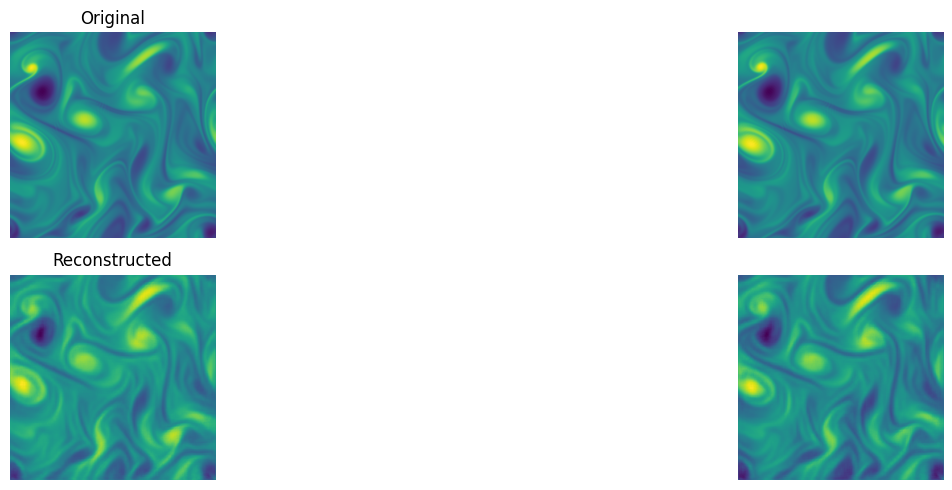

Reconstruction visualization saved


In [12]:
# Visualize reconstructions
vqvae_model = lightning_model.vqvae
vqvae_model.eval()
device = next(vqvae_model.parameters()).device

# Set number of snapshots to visualize
nsnaps = 2

# Get a batch from validation set
batch = next(iter(val_loader))
hr_images = vqvae_model.get_input(batch, 'image').to(device)[:nsnaps]

reconstructed = torch.zeros_like(hr_images)

with torch.no_grad():
    for i in range(nsnaps):
        reconstructed[i], _ = vqvae_model(hr_images[i].unsqueeze(0))

# Plot original vs reconstructed
fig, axes = plt.subplots(2, nsnaps, figsize=(20, 5))

for i in range(nsnaps):
    # Original
    axes[0, i].imshow(hr_images[i, 0].cpu().numpy(), cmap='viridis')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original', fontsize=12)
    
    # Reconstructed
    axes[1, i].imshow(reconstructed[i, 0].cpu().numpy(), cmap='viridis')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Reconstructed', fontsize=12)

plt.tight_layout()
plt.savefig('vqvae_reconstructions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Reconstruction visualization saved")

In [13]:
# Test encoding and decoding separately
print("Testing VQ-VAE encode/decode pipeline...")

with torch.no_grad():
    # Get one sample
    test_img = hr_images[:1]
    print(f"Input shape: {test_img.shape}")
    
    # Encode (returns continuous latent)
    latent = vqvae_model.encode(test_img)
    print(f"Encoded latent shape: {latent.shape}")
    
    # Decode (includes quantization)
    reconstructed = vqvae_model.decode(latent)
    print(f"Reconstructed shape: {reconstructed.shape}")
    
    # Compute reconstruction error
    rec_error = torch.nn.functional.l1_loss(reconstructed, test_img)
    print(f"Reconstruction L1 error: {rec_error.item():.6f}")

print("\nVQ-VAE is ready for use in latent diffusion!")

Testing VQ-VAE encode/decode pipeline...
Input shape: torch.Size([1, 3, 256, 256])
Encoded latent shape: torch.Size([1, 3, 64, 64])
Reconstructed shape: torch.Size([1, 3, 256, 256])
Reconstruction L1 error: 0.035921

VQ-VAE is ready for use in latent diffusion!
